
# Collateralized Exposure 

This dashboard demonstrates the modelling and imapct of collateral in exposure simulations 
- Portfolio: EUR, USD and GBP Swaps
- Analytics: Exposure simulation and XVA, default and close-out time grid

Prerequisites:
- This notebook assumes a standard installation of Python 3
- VRE Python module installed: run "pip install vannarho-risk-engine" to get the latest version

## Launch VRE

Kick off a process in VRE, loading all inputs from Input/vre.xml and the files referenced therein. 
This is equivalent to using the VRE command line application.

Running the following cells loads all inputs (portfolio, configurations) and kicks of a **Monte Carlo simulation**: 
- It evolves today's market into the future along alternative paths
- ages the portfolio on each path
- revalues the portfolio through its life and across all paths.

This requires a "model" of the market. The "Cross Asset Model" in VRE covers the evolution of the market across six asset/risk classes, it evolves
- yield curves
- fx rates
- inflation rates
- equity prices
- commodity prices
- credit spreads

and there are a few choices of the model components in VRE (LGM-1f vs Hull-White-1f/2f for yield curves, Dodgson-Kainth or Jarrow-Yildirim for Inflation, etc.).

This process takes about a minute. Run-time generally depends on the number of paths we want to generate, portfolio size/complexity and number of time grid points.

In [1]:
from VRE import *
import sys, time, math
sys.path.append('..')
import utilities

params = Parameters()
params.fromFile("Input/vre.xml")

vre = VREApp(params)

In [2]:
vre.run()

utilities.checkErrorsAndRunTime(vre)

Run time: 27.60 sec
Errors: 0


The simulation process finally produces an NPV "cube": valuations for each trade, through time and across all simulation paths (3 * 289 * 1000 in the case above). It is reused a few times below.

## Uncollateralized Exposure

The simulation produces an NPV "cube": valuations for each trade, through time and across many simulation paths (3 * 289 * 1000 in the case above).

"Exposure" is then computed by post-processing this information, aggregating across all trades in the netting set, and averaging over discounted positive resp. negative NPVs across the simulation paths:   

\begin{align}
\mathit{EPE}(t) &= \mathbb{E}^N\left[ \frac{[\mathit{NPV}(t)]^+}{N(t)} \right] \\
\mathit{ENE}(t) &= \mathbb{E}^N\left[ \frac{[-\mathit{NPV}(t)]^+}{N(t)} \right]
\end{align}

The Expected Positive Exposure (EPE) is our view of exposure, the Expected Negative Exposure (ENE) is the counterparty's perspective. 

These expectations feed e.g. into the CVA and DVA calculation:

\begin{align}
\mathit{CVA} &= \sum_{i} \mathit{PD}_{theirs}(t_{i-1},t_i)\times\mathit{LGD}_{theirs}\times \mathit{EPE}(t_i) \\
\mathit{DVA} &= \sum_{i} \mathit{PD}_{ours}(t_{i-1},t_i)\times\mathit{LGD}_{ours}\times \mathit{ENE}(t_i) 
\end{align}


In [3]:
utilities.writeList(vre.getReportNames())


- fixings
- pricingstats
- colva_nettingset_CPTY_A
- curves
- exposure_trade_Swap_2
- exposure_trade_Swap_3
- npv
- cashflow
- rawcube
- exposure_trade_Swap_1
- todaysmarketcalibration
- runtimes
- xva
- netcube
- dividends
- exposure_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- marketdata


Plot EPE and ENE, single trades and netting set: 

In [4]:
report_nocol = vre.getReport("exposure_nettingset_CPTY_A")
report_1 = vre.getReport("exposure_trade_Swap_1")
report_2 = vre.getReport("exposure_trade_Swap_2")
report_3 = vre.getReport("exposure_trade_Swap_3")

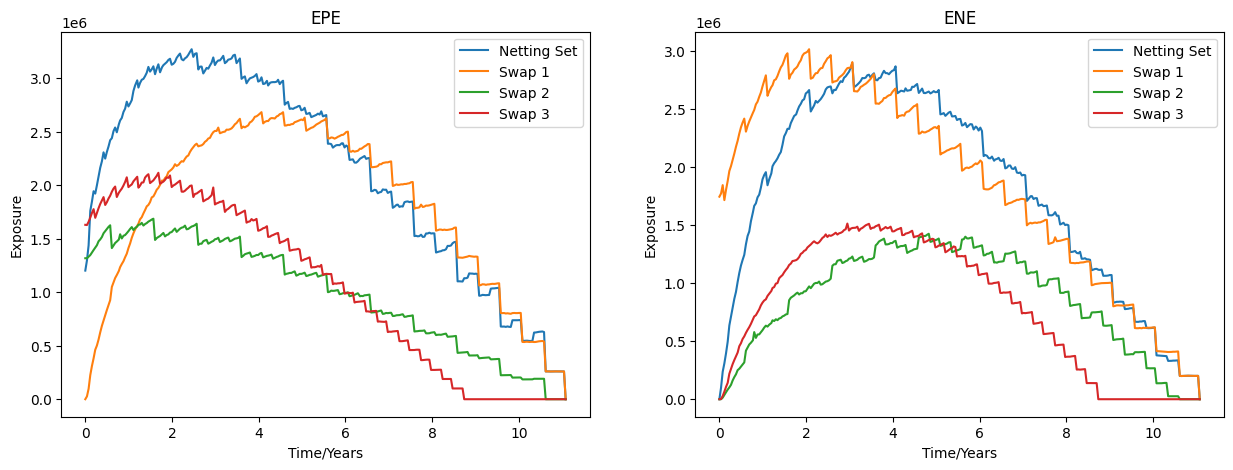

In [5]:
time = report_1.dataAsReal(2)
epe_1 = report_1.dataAsReal(3);
ene_1 = report_1.dataAsReal(4);
epe_2 = report_2.dataAsReal(3);
ene_2 = report_2.dataAsReal(4);
epe_3 = report_3.dataAsReal(3);
ene_3 = report_3.dataAsReal(4);
epe_nocol = report_nocol.dataAsReal(3);
ene_nocol = report_nocol.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_nocol, label='Netting Set')
ax0.plot(time, epe_1, label='Swap 1')
ax0.plot(time, epe_2, label='Swap 2')
ax0.plot(time, epe_3, label='Swap 3')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Exposure')
ax0.set_title('EPE')
ax0.legend()

ax1.plot(time, ene_nocol, label='Netting Set')
ax1.plot(time, ene_1, label='Swap 1')
ax1.plot(time, ene_2, label='Swap 2')
ax1.plot(time, ene_3, label='Swap 3')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='Exposure')
ax1.set_title('ENE')
ax1.legend()

plt.show()

# Cash Collateral with Non-Zero Threshold

Collaterealized Exposure

\begin{align}
\mathit{EPE}(t) &= \mathbb{E}^N\left[ \frac{(NPV(t)-C(t))^+}{N(t)} \right] \\
\mathit{ENE}(t) &= \mathbb{E}^N\left[ \frac{(-NPV(t)+C(t))^+}{N(t)} \right]
\end{align}

where $C(t)$ is the collateral balance from our perspective.

In an ideal world (continuous posting of collateral, equivalent to the netting set NPV), the exposures vanish. 

In reality they don't, because of details of the CSA such us thresholds (THs), minimum transfer amounts (MTAs) or delays in the collateral process. Even without TH and MTA, if a counterparty default occurs, it might take us time to realize this. During this period we may still be paying to the counterparty while they do not fulfil their obligations any more. And even if we stop paying immediately, it will take time to close out positions in the market. In that Margin Period of Risk (MPoR), the market eveolves and valuation can deteriorate. This effect needs to be taken into account. 

In VRE we simulate the netting set collateral balance taking CSA details into account that are modelled in the netting*.xml file. We consider a few basic cases below and illustrate impact on remaining exposures.

### First case with non-zero threshold:

We have prepared a second configuration for this case
- vre_threshold.xml 
- netting_threshold.xml

We re-run VRE now, but we do not need to generate the NPV cube again. We load the cube from our previous run. This allows quickly exploring alternative collateral settings (in netting_threshold.xml) in separate post-processor runs. We use a separate VRE instance here to keep all previous results.

Running the following cell should take a few seconds instead of a minute.

In [6]:
xml = "Input/vre_threshold.xml"
params = Parameters()
params.fromFile(xml)
vre_threshold = VREApp(params)

vre_threshold.run()

utilities.checkErrorsAndRunTime(vre_threshold)

Run time: 1.38 sec
Errors: 0


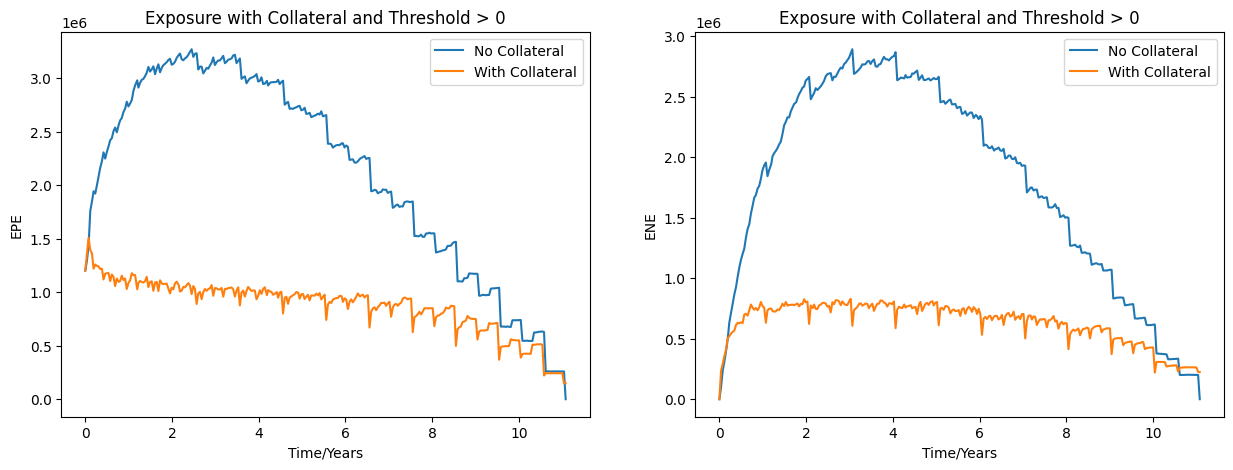

In [7]:
report_th = vre_threshold.getReport("exposure_nettingset_CPTY_A")

time = report_nocol.dataAsReal(2)
epe_th = report_th.dataAsReal(3);
ene_th = report_th.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_nocol, label='No Collateral')
ax0.plot(time, epe_th, label='With Collateral')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='EPE')
ax0.set_title('Exposure with Collateral and Threshold > 0')
ax0.legend()

ax1.plot(time, ene_nocol, label='No Collateral')
ax1.plot(time, ene_th, label='With Collateral')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='ENE')
ax1.set_title('Exposure with Collateral and Threshold > 0')
ax1.legend()

plt.show()

# Cash Collateral with Zero Threshold, but Non-Zero MTA

Second case, see
- vre_mta.xml 
- netting_mta.xml

Re-run the post-processor:

In [8]:
xml = "Input/vre_mta.xml"
params = Parameters()
params.fromFile(xml)
vre_mta = VREApp(params)
vre_mta.run()

utilities.checkErrorsAndRunTime(vre_mta)      

Run time: 1.35 sec
Errors: 0


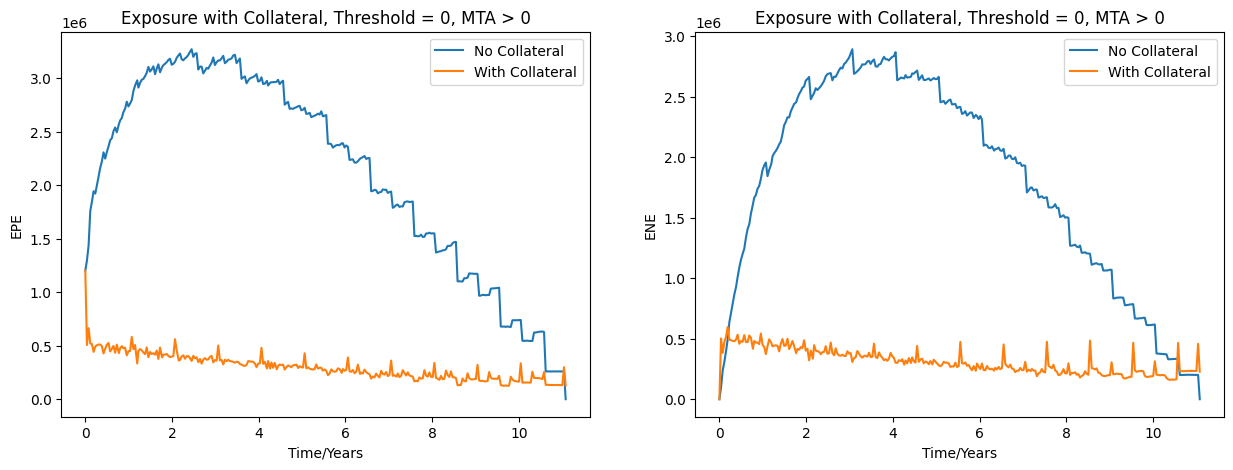

In [9]:
report_mta = vre_mta.getReport("exposure_nettingset_CPTY_A")

time = report_nocol.dataAsReal(2)
epe_mta = report_mta.dataAsReal(3);
ene_mta = report_mta.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_nocol, label='No Collateral')
ax0.plot(time, epe_mta, label='With Collateral')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='EPE')
ax0.set_title('Exposure with Collateral, Threshold = 0, MTA > 0')
ax0.legend()

ax1.plot(time, ene_nocol, label='No Collateral')
ax1.plot(time, ene_mta, label='With Collateral')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='ENE')
ax1.set_title('Exposure with Collateral, Threshold = 0, MTA > 0')
ax1.legend()

plt.show()

# Cash Collateral with Perfect CSA (Zero Threshold and Zero MTA)

Third case:
- vre_mpor.xml 
- netting_mpor.xml

Re-run post processor:

In [10]:
xml = "Input/vre_mpor.xml"
params = Parameters()
params.fromFile(xml)
vre_mpor = VREApp(params)
vre_mpor.run()

utilities.checkErrorsAndRunTime(vre_mpor)

Run time: 1.42 sec
Errors: 0


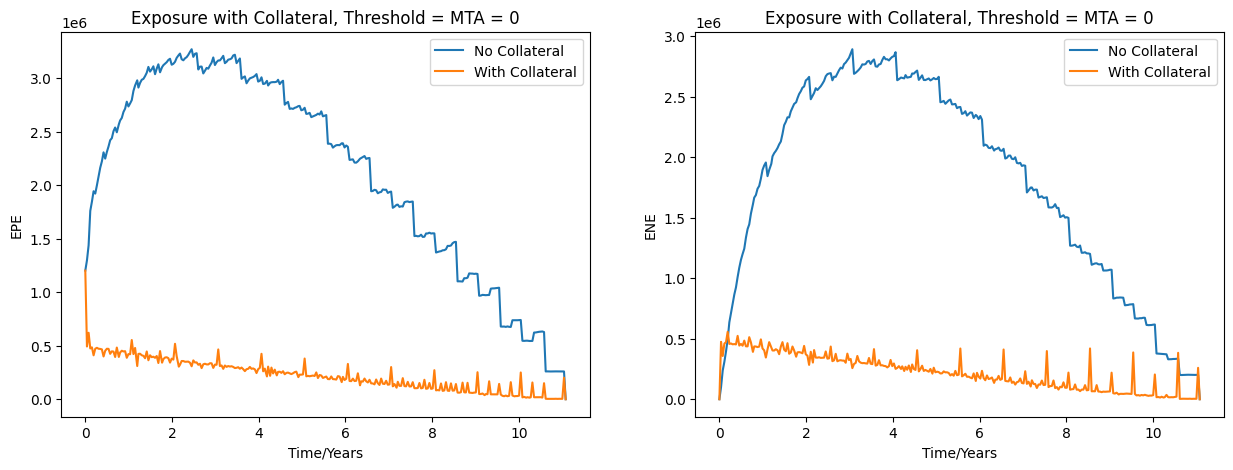

In [11]:
report_mpor = vre_mpor.getReport("exposure_nettingset_CPTY_A")

time = report_nocol.dataAsReal(2)
epe_mpor = report_mpor.dataAsReal(3);
ene_mpor = report_mpor.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_nocol, label='No Collateral')
ax0.plot(time, epe_mpor, label='With Collateral')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='EPE')
ax0.set_title('Exposure with Collateral, Threshold = MTA = 0')
ax0.legend()

ax1.plot(time, ene_nocol, label='No Collateral')
ax1.plot(time, ene_mpor, label='With Collateral')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='ENE')
ax1.set_title('Exposure with Collateral, Threshold = MTA = 0')
ax1.legend()

plt.show()

# Cash Collateral with Perfect CSA and Initial Margin

Case:
- vre_external_im.xml 
- netting_mpor.xml

In this case we take initial margin into account, i.e. the collateral balance $C(t)$ in our exposure formulas contains both VM and IM, and we expect further redcued exposure.

VRE allows feeding a (deterministic) IM evolution, i.e. same IM across paths, generated externally, into the post-processor. 

The next post-processor run demonstrates this IM feed and its impact:

In [12]:
xml = "Input/vre_external_im.xml"
params = Parameters()
params.fromFile(xml)
vre_im = VREApp(params)
vre_im.run()

utilities.checkErrorsAndRunTime(vre_im)

Run time: 1.72 sec
Errors: 0


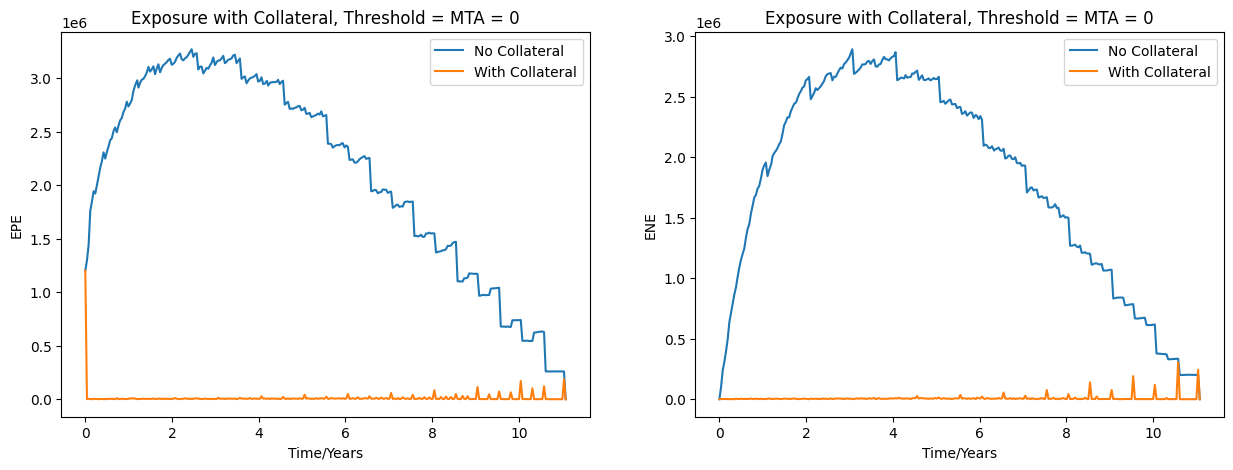

In [13]:
report_im = vre_im.getReport("exposure_nettingset_CPTY_A")

time = report_nocol.dataAsReal(2)
epe_im = report_im.dataAsReal(3);
ene_im = report_im.dataAsReal(4);
    
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_nocol, label='No Collateral')
ax0.plot(time, epe_im, label='With Collateral')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='EPE')
ax0.set_title('Exposure with Collateral, Threshold = MTA = 0')
ax0.legend()

ax1.plot(time, ene_nocol, label='No Collateral')
ax1.plot(time, ene_im, label='With Collateral')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='ENE')
ax1.set_title('Exposure with Collateral, Threshold = MTA = 0')
ax1.legend()

plt.show()

# Dynamic Initial Margin

Final case:
- vre_dim.xml 
- simulation_dim.xml
- netting_mpor.xml

In VRE we support a "Dynamic Initial Margin" model that constructs **path-wise IM evolution** from the NPV cube. The model uses a regression-based approach to compute conditional variances of the NPV moves over consecutive simulation dates. From variances we compute standard deviations which are scaled up with a Gaussian assumption to the typical 99% quantile as a proxy for Initial Margin. We can apply an additional "t0 scaling" to match the true IM for the portfolio as of today. 

To demonstrate that model, we run the NPV cube again, this time with a **StickyDate** specification in simulation_dim.xml in order to avoid spikes in the IM evolution due to cashflows, i.e. to use clean NPV variances for the IM estimate. 

Re-run cube generation and post-processor (takes about a minute):

In [14]:
xml = "Input/vre_dim.xml"
params = Parameters()
params.fromFile(xml)
vre_dim = VREApp(params)
vre_dim.run()

utilities.checkErrorsAndRunTime(vre_dim)    

Run time: 28.55 sec
Errors: 0


In [15]:
utilities.writeList(vre_dim.getReportNames())


- fixings
- pricingstats
- colva_nettingset_CPTY_A
- dim_regression_0
- exposure_trade_Swap_2
- exposure_trade_Swap_3
- dim_evolution
- exposure_trade_Swap_1
- todaysmarketcalibration
- runtimes
- xva
- dim_distribution
- dividends
- dim_cube
- exposure_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- marketdata


In [16]:
report_im_evolution = vre_dim.getReport("dim_evolution")
report_vm_evolution = vre_dim.getReport("colva_nettingset_CPTY_A")
report_regression = vre_dim.getReport("dim_regression_0")

In [17]:
utilities.checkReportStructure("dim_evolution", report_im_evolution)

Report:  dim_evolution
columns: 9
rows:    289

Column Header               Type     TypeString
0      TimeStep             0        Size      
1      Date                 3        Date      
2      DaysInPeriod         0        Size      
3      ZeroOrderDIM         1        Real      
4      AverageDIM           1        Real      
5      AverageFLOW          1        Real      
6      SimpleDIM            1        Real      
7      NettingSet           2        string    
8      Time                 1        Real      


In [18]:
utilities.checkReportStructure("colva_nettingset_CPTY_A", report_vm_evolution)

Report:  colva_nettingset_CPTY_A
columns: 8
rows:    290

Column Header               Type     TypeString
0      NettingSet           2        string    
1      Date                 3        Date      
2      Time                 1        Real      
3      CollateralBalance    1        Real      
4      COLVA Increment      1        Real      
5      COLVA                1        Real      
6      CollateralFloor Increment 1        Real      
7      CollateralFloor      1        Real      


### DIM evolution as average IM across paths

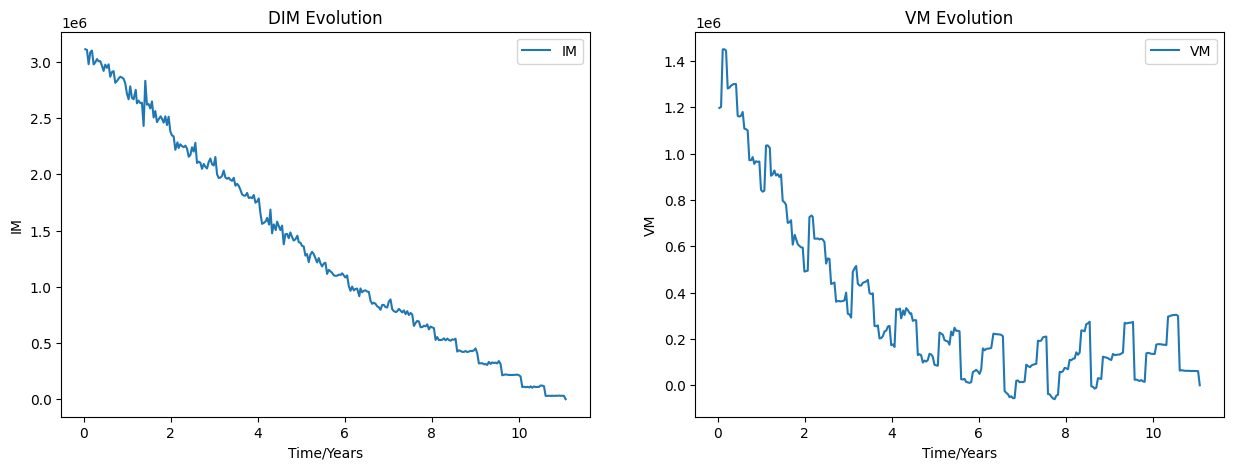

In [19]:
time = report_im_evolution.dataAsReal(8)
avgDim = report_im_evolution.dataAsReal(4)

time2 = report_vm_evolution.dataAsReal(2)
colBalance = report_vm_evolution.dataAsReal(3)
# todo: fix #N/A in row 1 of the vm report, skip for now
time2 = time2[1:]
colBalance = colBalance[1:]

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(time, avgDim, label='IM')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='IM')
ax0.set_title('DIM Evolution')
ax0.legend()

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(time2, colBalance, label='VM')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='VM')
ax1.set_title('VM Evolution')
ax1.legend()

plt.show()

The DIM evolution shown here is the Expected IM (averaged across paths) - this is the evolution that we have fed as an external input into the previous case.

Final graph: Regression data at grid point 100. The slope of the regression curve indicates by how much the IM varies across paths.

### DIM regression to estimate IM for each path at a given point in time

- We pick one point in time, grid point 100 here, about year 4 on the bi-weekly grid
- **Regression plot**: Consider all clean NPV moves (on all paths) across the next bi-weekly period, square them and plot against regressor (NPV in this case)
- **Simple DIM** estimate: pick the upper 99% quantile of clean NPV moves
- **Zero Order DIM** estimate: Compute standard deviation of clean NPV moves, scale up to 99% quantile with Gaussian assumption (factor 2.33)
- **First Order DIM** estimate: Compute **conditional variance** of clean NPV moves by first order **regression**, yields a path-dependent IM estimate; NPV  as single regressor here

In [20]:
utilities.checkReportStructure("dim_regression_0", report_regression)

Report:  dim_regression_0
columns: 8
rows:    1000

Column Header               Type     TypeString
0      Sample               0        Size      
1      Regressor_0_NPV      1        Real      
2      RegressionDIM        1        Real      
3      LocalDIM             1        Real      
4      ExpectedDIM          1        Real      
5      ZeroOrderDIM         1        Real      
6      DeltaNPV             1        Real      
7      SimpleDIM            1        Real      


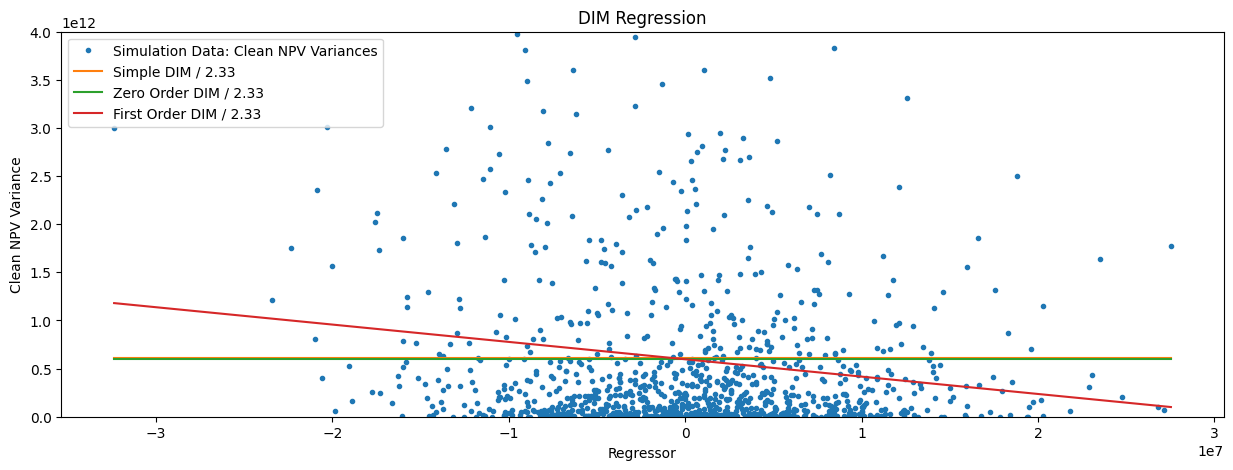

In [21]:
regressor = report_regression.dataAsReal(1)
firstOrderDim = report_regression.dataAsReal(2)
zeroOrderDim = report_regression.dataAsReal(5)
deltaNpv = report_regression.dataAsReal(6)
simpleDim = report_regression.dataAsReal(7)

# take out the scaling to the 99% quantile, divide DIM estimates by 2.33
# take squares to consider variances
x = []
deltaNpv2 = []
zeroOrderDim2 = []
firstOrderDim2 = []
simpleDim2 = []
for i in range(0, len(deltaNpv)-1):
    x.append(regressor[i])
    deltaNpv2.append(pow(float(deltaNpv[i]), 2))                 # take square to visualize variances
    zeroOrderDim2.append(pow(float(zeroOrderDim[i]/2.33), 2))    # divide by 2.33 to take out the 99% quantile scaling
    firstOrderDim2.append(pow(float(firstOrderDim[i]/2.33), 2))  # "
    simpleDim2.append(pow(float(simpleDim[i]/2.33), 2))          # "

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=1)

cutoff = 4e12
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(x, deltaNpv2, label='Simulation Data: Clean NPV Variances', marker='.', linestyle='')
ax0.plot(x, simpleDim2, label='Simple DIM / 2.33')
ax0.plot(x, zeroOrderDim2, label='Zero Order DIM / 2.33')
ax0.plot(x, firstOrderDim2, label='First Order DIM / 2.33')
ax0.set(xlabel='Regressor')
ax0.set(ylabel='Clean NPV Variance')
ax0.set_title('DIM Regression')
ax0.set_ylim([0, cutoff])
ax0.legend()

plt.show()

# Margin Value Adjustment

Initial Margin suppresses the residual credit exposure, but needs to be funded and causes additional cost throught the life of a collateralized portfolio.

The present value of the net funding (borrowing minus investment) cost of posted IM is another value adjustment

\begin{align}
\mathit{MVA} &= \sum_{i=1}^n (f_b - s_I)\times \delta_i \times S_{ours}(t_i)\times S_{theirs}(t_i) \times \mathbb{E}^N\left[
\frac{\mathit{DIM}(t_i)}{N(t_i)}\right].  
\end{align}

which is another output of VRE.